# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

In [ ]:
messages = [HumanMessage(content="Hi my name is Soutrik", name="User")]
messages.append(AIMessage(content="Hi Soutrik, nice to meet you!", name="Assistant"))
messages.append(HumanMessage(content="Can you please give me some details about mount Abu ?", name="User"))

In [4]:
for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: User

Hi my name is Soutrik
================================== Ai Message ==================================
Name: Assistant

Hi Soutrik, nice to meet you!
================================ Human Message =================================
Name: User

Can you please give me some details about mount Abu ?


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [5]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
print(result)
print(result.usage_metadata)
print(result.response_metadata)

content="Mount Abu is a popular hill station located in the Aravalli Range in the state of Rajasthan, India. Here are some key details about Mount Abu:\n\n1. **Location**: It is situated in the Sirohi district of Rajasthan, close to the Gujarat border, and is the only hill station in Rajasthan.\n\n2. **Climate**: The climate is relatively cool compared to the surrounding desert regions, with temperatures ranging from pleasant to moderately warm. The summer season is from April to June, monsoon from July to September, and winter from November to February.\n\n3. **Tourist Attractions**:\n   - **Dilwara Temples**: Famous for their stunning marble architecture and intricate carvings, these Jain temples are a major attraction.\n   - **Nakki Lake**: A picturesque lake surrounded by hills and forests, ideal for boating and picnics.\n   - **Guru Shikhar**: The highest peak in the Aravalli Range, offering panoramic views of the surrounding area.\n   - **Achalgarh Fort**: A historical fort with 

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [10]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_ero6sT41Pig4GUKIE0Zs5Wcv',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

In [14]:
# conventionally we would use a TypedDict to define the state of the graph
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [15]:
# same as above but with a different approach
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

In [16]:
# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance"),
]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='fb5670f6-7a66-429d-a6d7-4dde4eb4546d'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='9ba958a7-98ad-4514-b2e8-b2f4f33b5f2e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='5fcfa95d-ac5a-43a3-8225-e8e04214cdf9')]

## Our graph

Now, lets use `MessagesState` with a graph.

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

In [20]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [21]:
def tool_call(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

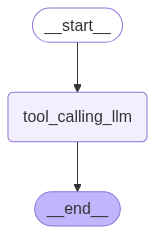

In [22]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_call)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [24]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ED51q9BMQQKzN6Nop6dUjAmp)
 Call ID: call_ED51q9BMQQKzN6Nop6dUjAmp
  Args:
    a: 2
    b: 3
